## Speech Recognition with 3D Waves##

*train.7z - Contains a few informational files and a folder of audio files. The audio folder contains subfolders with 1 second clips of voice commands, with the folder name being the label of the audio clip. There are more labels that should be predicted. The labels you will need to predict in Test are yes, no, up, down, left, right, on, off, stop, go. Everything else should be considered either unknown or silence. The folder _background_noise_ contains longer clips of "silence" that you can break up and use as training input.

The files contained in the training audio are not uniquely named across labels, but they are unique if you include the label folder. For example, 00f0204f_nohash_0.wav is found in 14 folders, but that file is a different speech command in each folder.

The files are named so the first element is the subject id of the person who gave the voice command, and the last element indicated repeated commands. Repeated commands are when the subject repeats the same word multiple times. Subject id is not provided for the test data, and you can assume that the majority of commands in the test data were from subjects not seen in train.

You can expect some inconsistencies in the properties of the training data (e.g., length of the audio).


Speech Commands Data Set v0.01
This is a set of one-second .wav audio files, each containing a single spoken English word. These words are from a small set of commands, and are spoken by a variety of different speakers. The audio files are organized into folders based on the word they contain, and this data set is designed to help train simple machine learning models.


In [1]:
SAMPLE_RATE = 128 # [256 - > 16000] Wave Focus Index


import os
from pathlib import Path
import IPython.display as ipd

import os
from os.path import isdir, join
from pathlib import Path

import pandas as pd 
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
from collections import Counter

%matplotlib inline

from subprocess import check_output

In [2]:
folders = '/home/parmar/Downloads/Datasets/train/audio'

def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

In [3]:
cols = ['class', 'filename', 'samplerate']
cid = 1
for cid in range(SAMPLE_RATE):
    cols.append("S"+str(cid))

train =  pd.DataFrame( columns = cols)
train[:5]

train_audio_path = '/home/parmar/Downloads/Datasets/train/audio'

train_labels = os.listdir(train_audio_path)
train_labels.remove('_background_noise_')
print(f'Number of labels: {len(train_labels)}')

labels_to_keep = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go', 'silence']

i = 1
train_file_labels = dict()
for label in train_labels:
    files = os.listdir(train_audio_path + '/' + label)
    for f in files:
        train_file_labels[label + '/' + f] = label
        sample_rate, samples = wavfile.read(str(train_audio_path) + '/' + label + '/' + f)
        resampled = signal.resample(samples, int(SAMPLE_RATE/sample_rate * samples.shape[0]))
        if len(resampled) == SAMPLE_RATE:
            arow = [label, f, sample_rate]
            sraw = resampled.tolist()
            rawdata = arow + sraw
            train.loc[len(train)] = rawdata
            print(f + " : " + str(i), end='\r')
            i = i + 1
        else:
            print('Wrong samplerate!    ', end='\r')

Number of labels: 30


In [4]:
train.to_csv("LCFR_SPEECH_FULL_TRAIN_" + str(SAMPLE_RATE) + ".csv")

In [5]:
train['class'] = train['class'].astype('category')
train['y'] = train['class'].cat.codes

In [6]:
train['y'].value_counts()

29    2203
21    2199
22    2174
13    2174
19    2170
11    2165
6     2161
7     2158
28    2157
18    2155
4     2152
23    2143
15    2143
25    2140
5     2111
16    2105
17    2103
8     2101
14    2098
26    2062
12    1578
20    1578
10    1560
9     1549
3     1547
27    1525
24    1521
1     1521
2     1515
0     1484
Name: y, dtype: int64

In [7]:
PROF_train = train

PROF_train = PROF_train.drop('class', 1)
PROF_train = PROF_train.drop('filename', 1)
PROF_train = PROF_train.drop('samplerate', 1)

In [8]:
PROF_train[:10]

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S119,S120,S121,S122,S123,S124,S125,S126,S127,y
0,-0.593683,0.322088,-0.288243,0.319011,0.189994,-0.424861,-1.001531,6.245334,-5.851340,5.159421,...,0.145005,0.155567,0.134497,-0.292667,0.273383,-0.214352,0.093234,0.013194,-0.032106,16
1,140.345446,-18.179736,-8.513826,-1.119343,9.908803,-15.882764,17.748357,-16.381819,48.629328,-37.508594,...,-8.843934,10.665240,-9.287724,25.565894,-32.145972,28.335439,-42.733931,51.084796,-51.581605,16
2,-0.193199,0.020024,-0.017779,0.068319,-0.016549,0.151000,-0.288438,0.189900,-0.419977,0.335843,...,-0.586892,0.024656,0.537057,0.298245,-0.208372,-0.467529,-0.014484,-0.038301,0.216084,16
3,-0.273142,0.261251,-0.273217,0.238948,-0.263011,0.270379,-0.277051,0.271387,-0.261399,0.266185,...,0.238434,-0.253658,0.284164,-0.276106,0.288483,-0.251943,0.265656,-0.257662,0.253914,16
4,-67.136476,-221.260384,286.820202,-441.148910,386.199331,-63.541358,192.368622,75.966602,-280.283021,41.063112,...,-16.669585,1.770798,-182.956277,102.271719,-294.349014,464.705989,-289.175621,284.978569,-381.231060,16
5,323.256716,244.662224,254.191876,253.810646,242.184728,249.885111,234.690818,292.597436,195.614246,278.913223,...,227.771532,276.146543,198.244299,295.514336,210.445556,293.403820,202.360928,279.243635,210.013581,16
6,0.110191,-0.062165,0.019730,-0.131233,0.046677,-0.098061,0.058064,-0.040386,0.170908,-0.055099,...,-0.072539,-0.104853,-0.080410,0.050532,-0.104121,0.052999,-0.126859,0.041110,-0.143101,16
7,-0.482081,-1.075590,0.411921,-1.132043,0.405247,-0.942404,-0.135376,-0.431285,-0.010968,-0.411236,...,-3.787215,0.186025,0.970771,1.325710,-1.204452,1.521866,-0.703594,0.621318,-0.406792,16
8,-26.122536,7.578898,42.817681,22.401879,35.192236,-71.749884,-59.759437,-150.885278,4.003187,20.254953,...,-137.763166,-76.624669,53.971619,19.034856,1.682441,35.091522,-29.162296,-28.334130,-9.964544,16
9,4.533375,-4.980417,4.277478,-3.543815,3.399858,-3.130166,2.658139,-2.442571,2.356020,-2.006234,...,11.153415,8.135573,-10.445400,13.013684,-4.864862,6.329631,4.963181,-1.405531,-6.382729,16


In [9]:
data = [go.Bar(
            x = PROF_train["y"].value_counts().index.values,
            y = PROF_train["y"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Class distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=2000, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(PROF_train.drop(['y'],axis=1), PROF_train.y)
features = PROF_train.drop(['y'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [11]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [12]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Speech dataset / Feature importances',
     width = 800, height = 500,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=4, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(PROF_train.drop(['y'],axis=1), PROF_train.y)
features = PROF_train.drop(['y'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [14]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 10,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

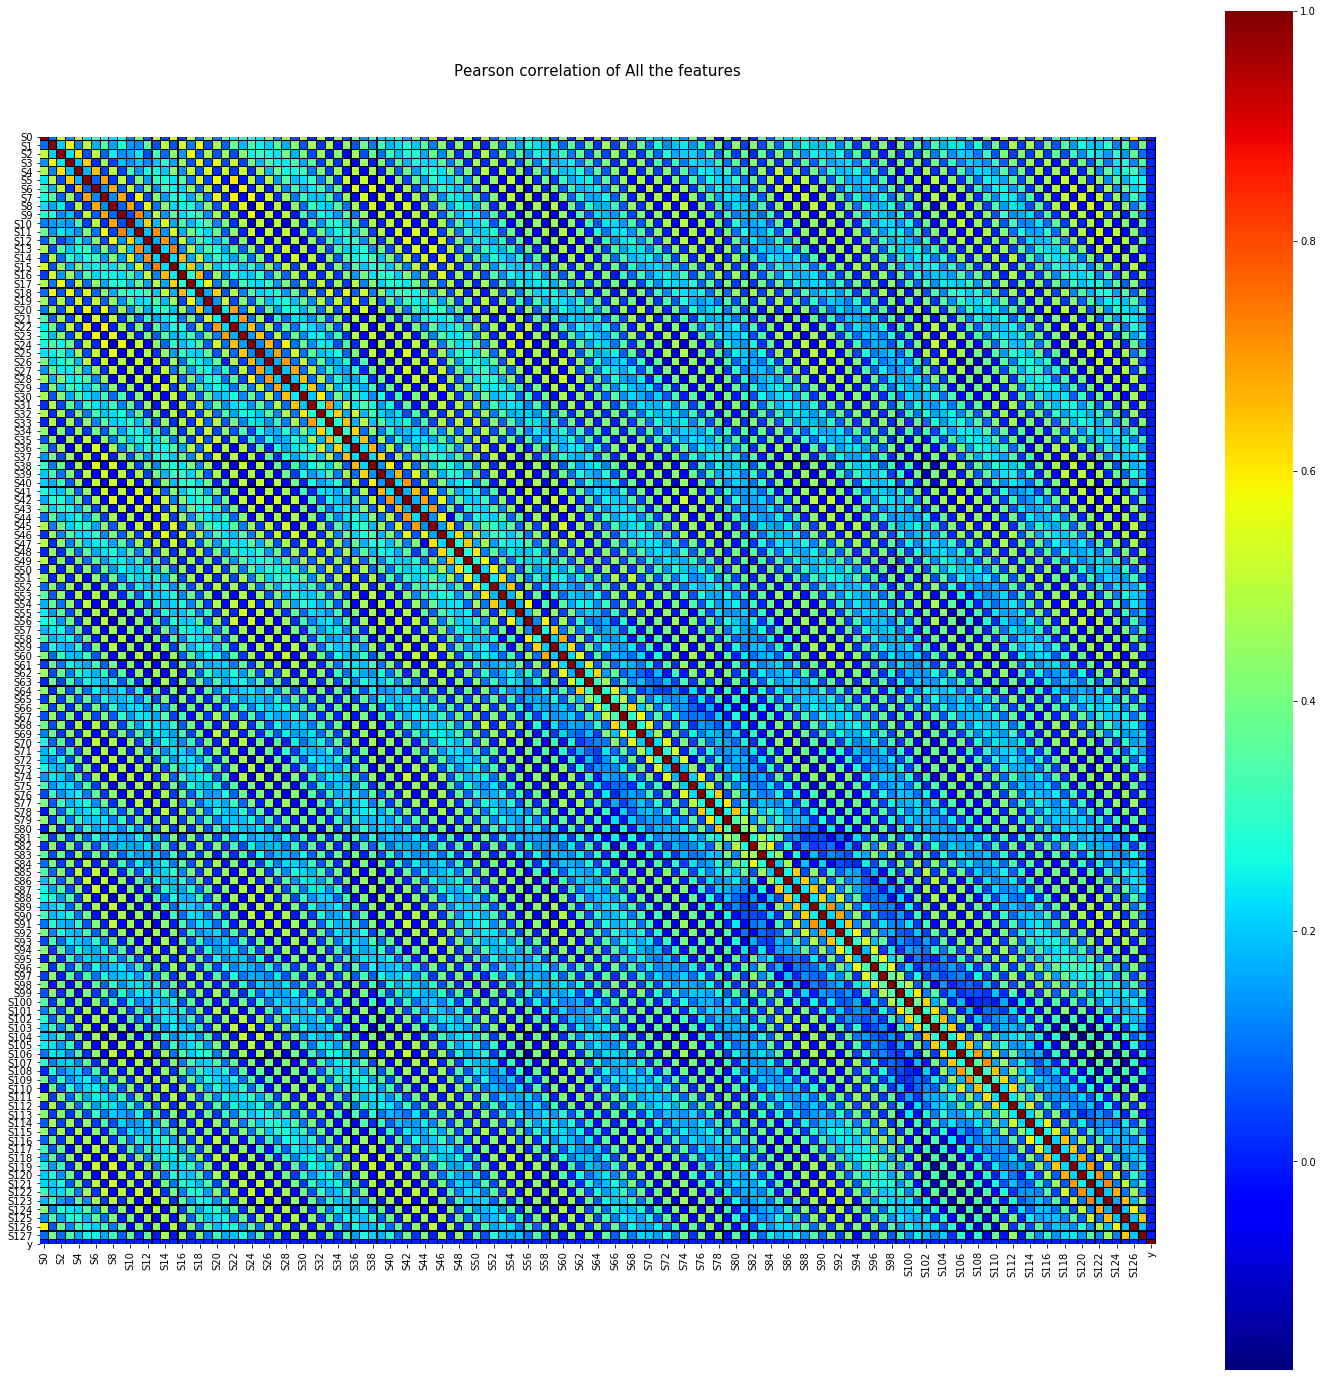

In [15]:
# The Wave

colormap = plt.cm.jet
plt.figure(figsize=(25,25))
plt.title('Pearson correlation of All the features', y=1.05, size=15)
sns.heatmap(PROF_train.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='black', annot=False)